<a href="https://colab.research.google.com/github/getaccept/notebooks/blob/master/API_Create_Users_from_GSheet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bulk users in batch from Google Sheet using GetAccept API

Script to bulk create new users from a list in a Google Sheet spreadsheet. Email address must be placed on column #1 having the list starting from row #2.

The other columns are optional.
* available fields: __first_name, last_name, email, title, phone, mobile, role, note__
* __role__ column should be one of the values *user, manager, admin* and **it's case sensitive.**
* __team_id__ column should be the

__** Example ***__

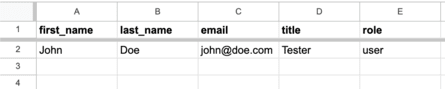

In [ ]:
# import dependencies
import requests
import concurrent.futures
import ipywidgets as widgets
from datetime import date
import time
from google.colab import auth
import gspread
from google.auth import default

#Constants
BASE_URL = "https://api.getaccept.com/v1"
SOURCE_ENTITY_ID = ""
#@title ↓↓ Click here to start
#@markdown This step might take a few seconds to run. <br>
#@markdown Then use __shift+enter__ key or click ► left of each step to go through the flow

In [ ]:
email_widget = widgets.Text(
    value="",
    placeholder="Enter login email",
    description="Email:",
    disabled=False
)
password_widget = widgets.Password(
    value="",
    placeholder="Enter password",
    description="Password:",
    disabled=False
)
#@markdown Use the form below to fill in login details to your entity in GetAccept and then run next cell to login
widgets.VBox([email_widget, password_widget])

In [ ]:
#@markdown Login and store API token
if email_widget.value and password_widget.value:
  payload = { "email": email_widget.value, "password": password_widget.value}
  if SOURCE_ENTITY_ID != "":
    payload["entity_id"] = SOURCE_ENTITY_ID
  response = requests.post(BASE_URL+"/auth", json=payload)
  data = response.json()
  if "access_token" in data:
    source_auth_headers = { "Authorization": "bearer " + data["access_token"]}
  else:
    raise TypeError(data["errors"], "Please check your credentials")
  # Check login and list entities
  response = requests.get(BASE_URL+"/users/me", headers=source_auth_headers)
  user_data = response.json()
  print("Logged in as " + user_data["user"]["first_name"] + " on entity " + user_data["user"]["entity_name"])
  SOURCE_ENTITY_ID = user_data["user"]["entity_id"]
else:
  raise TypeError("Could not login, missing email or password!")

In [ ]:
#@markdown Select the entity you would like to create users on. When you're done, select the next cell and run.
source_entity_list = list(map(lambda x: (x["name"],x["id"]), user_data["entities"]))
source_entity_picker = widgets.Select(
    options=source_entity_list,
    value=SOURCE_ENTITY_ID,
)
source_entity_picker

In [ ]:
#@markdown Verifying entity token of source...
if source_entity_picker.value != SOURCE_ENTITY_ID:
  # Switch entity
  response = requests.get(BASE_URL+"/refresh/"+source_entity_picker.value, headers=source_auth_headers)
  data = response.json()
  if "access_token" in data:
    source_auth_headers = { "Authorization": "bearer " + data["access_token"]}
  SOURCE_ENTITY_ID = source_entity_picker.value
print("Token verified")

In [ ]:
#@markdown Authenticate to Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)


In [ ]:
#@markdown Enter Google Sheet Spreadsheet URL from your browser
gsheet_url_picker = widgets.Text(
    value="",
    placeholder="ex. https://docs.google.com/spreadsheets/d/xyz...",
    description="URL:",
    disabled=False
)
gsheet_url_picker

In [ ]:
#@markdown Select the worksheet with document data
doc = gc.open_by_url(gsheet_url_picker.value)
if doc:
  sheets = doc.worksheets()
  worksheet_list = list(map(lambda x: (x.title,x.id), sheets))
  worksheet_picker = widgets.Select(
      options=worksheet_list,
      value=0,
  )
else:
    raise TypeError("Could not access spreadsheet!")
worksheet_picker


In [ ]:
#@markdown Optional settings
send_invitation_checkbox = widgets.Checkbox(
    value=False,
    description='Send email invitation to new users',
    disabled=False
)
send_invitation_checkbox

In [ ]:
#@markdown Run update for each row in the sheet:

def map_list_to_object(data):
    columns = data[0]
    result = []
    for row in data[1:]:
        row_dict = {columns[i]: row[i] for i in range(len(columns))}
        result.append(row_dict)
    return result

def create_user(payload, progress):
  result = requests.post(BASE_URL+"/users", json=payload, headers=source_auth_headers)
  if result.status_code == 200:
    create_user_result = result.json()
    progress.value += 1
  else:
    progress.value += 1
    create_user_result = result.json()
    if "message" in create_user_result:
      print("Error: " + create_user_result["message"] + " - " + str(payload["email"]))
    else:
      print(create_user_result)


# load and iterate through worksheet rows
worksheet = sheets[worksheet_picker.index]
rows = map_list_to_object(worksheet.get_all_values())
progress = widgets.IntProgress(
    value=0,
    min=0,
    max=len(rows),
    description='Progress:',
    bar_style='success',
    orientation='horizontal'
)
display(progress)
start_time = time.time()

with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
  for i,row in enumerate(rows):
    payload = {
      "first_name": row["first_name"] if "first_name" in row else "",
      "last_name": row["last_name"] if "last_name" in row else "",
      "email": row["email"],
      "title": row["title"] if "title" in row else "",
      "phone": row["phone"] if "phone" in row else "",
      "mobile": row["mobile"] if "mobile" in row else "",
      "note": row["note"] if "note" in row else "",
      "role": row["role"] if "role" in row and row["role"] in ["user","manager","admin"] else "user",
      "team_id": row["team_id"] if "team_id" in row else None,
      "skip_invitation": not send_invitation_checkbox.value
    }
    executor.submit(create_user, payload, progress)
end_time = time.time()
elapsed_time = end_time - start_time
print('%i users created in %f seconds' % (progress.value,elapsed_time))

In [ ]:
#@markdown ***Extra function to display team_ids for entity***

result = requests.get(BASE_URL+"/teams", headers=source_auth_headers)
if result.status_code == 200:
  team_result = result.json()
  progress.value += 1
else:
  print(result.text)
if team_result:
  print("- Team ID -\t - Team Name -")
  for team in team_result["teams"]:
    print(team["team_id"] + "\t" + team["name"])
else:
  print("No teams available")